In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import random
import rasterio
import numpy as np
import classic_algos.bicubic_interpolation as bicubic

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device )

cuda


In [65]:
class SatelliteSRDataset(Dataset):
    def __init__(self, root_dir, scale_factor=3, hr_patch_size=144, augment=True):
        super().__init__()
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.hr_patch_size = hr_patch_size
        self.augment = augment

        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read()  # C x H x W

        image_norm = image.astype(np.float32) / 255.0

        #random crop
        c, h, w = image_norm.shape
        top = random.randint(0, h - self.hr_patch_size)
        left = random.randint(0, w - self.hr_patch_size)
        hr_patch_np = image_norm[:, top:top+self.hr_patch_size, left:left+self.hr_patch_size]
        if self.augment:
            # Flip Horizontal
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=2)

            # Flip Vertical
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=1)

            # rotations
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                hr_patch_np = np.rot90(hr_patch_np, k, axes=(1, 2))

        hr_patch_np = np.ascontiguousarray(hr_patch_np.astype(np.float32))  # C x H x W, [0,1]
        hr_tensor = torch.from_numpy(hr_patch_np).float()

        # LR from augmented HR patch
        hr_patch_hwc = np.transpose(hr_patch_np, (1, 2, 0))  # H x W x C, [0,1]
        lr_size = self.hr_patch_size // self.scale_factor
        lr_numpy_hwc = bicubic.SR_bicubic(hr_patch_hwc, lr_size, lr_size, preserve_range=True, output_dtype=np.float32)
        lr_numpy = np.transpose(lr_numpy_hwc, (2, 0, 1))  # C x h_lr x w_lr
        lr_tensor = torch.from_numpy(lr_numpy.astype(np.float32))

        return lr_tensor, hr_tensor

In [66]:
class FSRCNN(nn.Module):
    def __init__(self):
        """
        d: filters dimension
        s: shrinking dimension
        m: mapping layers number
        """
        d, s, m = 56, 12, 4
        scale_factor = 3
        channels = 3
        super(FSRCNN, self).__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(channels, d, kernel_size=5, padding=2),
            nn.PReLU(d)
        )

        self.shrink = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU(s)
        )

        map_layers = []
        for _ in range(m):
            map_layers.extend([nn.Conv2d(s, s, kernel_size=3, padding=1),
                               nn.PReLU(s)
            ])
        self.mapping = nn.Sequential(*map_layers)

        self.expand = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU(d)
        )

        self.deconv = nn.ConvTranspose2d(d, channels,
                                         kernel_size=9,
                                         stride=3,
                                         padding=3,
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrink(x)
        x = self.mapping(x)
        x = self.expand(x)
        x = self.deconv(x)
        x = torch.clamp(x, 0.0, 1.0)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=0.001)


train

In [67]:
def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1 / (mse + 1e-20))

In [68]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from pathlib import Path
BATCH_SIZE = 128
EPOCHS = 200

TRAIN_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'train'
VAL_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = Path.home() / '.data' / 'fsrcnn_models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


In [69]:
train_dataset = SatelliteSRDataset(TRAIN_DIR)
val_dataset = SatelliteSRDataset(VAL_DIR, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [70]:
model = FSRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [71]:
loss = []
psnr_metric = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for lr_imgs, hr_imgs in tqdm(train_loader):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        optimizer.zero_grad()
        sr_imgs = model(lr_imgs)
        batch_loss = criterion(sr_imgs, hr_imgs)
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()
    avg_loss = epoch_loss / len(train_loader)
    loss.append(avg_loss)

    if epoch % 5 != 0:
        continue

    model.eval()
    epoch_psnr = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            epoch_psnr += PSNR(sr_imgs, hr_imgs).item()
    avg_psnr = epoch_psnr / len(val_loader)
    psnr_metric.append(avg_psnr)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB")
    torch.save(model.state_dict(), MODEL_DIR / f'fsrcnn_epoch_{epoch}.pth')

print("Training complete.")



  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:07,  1.81it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.71it/s]

 21%|██▏       | 3/14 [00:01<00:03,  3.22it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.40it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.74it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.02it/s]

 50%|█████     | 7/14 [00:02<00:01,  3.94it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  4.05it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.13it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.22it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.19it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  4.21it/s]

100%|██████████| 14/14 [00:03<00:00,  4.07it/s]


Epoch 0, Loss: 0.2256, PSNR: 7.16 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.06it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.99it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.01it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.92it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.81it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.69it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.60it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.60it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.47it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.52it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.62it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.68it/s]

100%|██████████| 14/14 [00:03<00:00,  3.92it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.89it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.94it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.91it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.84it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.69it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.69it/s]

 

Epoch 5, Loss: 0.0573, PSNR: 13.18 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.85it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.85it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.77it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.84it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.88it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.85it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.85it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.87it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.78it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.76it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.80it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.75it/s]

100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.55it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.34it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.39it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.53it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.62it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.58it/s]

 

Epoch 10, Loss: 0.0438, PSNR: 13.94 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.71it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.63it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.71it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.59it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.68it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.69it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.73it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.64it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.66it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.68it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.72it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.68it/s]

100%|██████████| 14/14 [00:03<00:00,  3.89it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.80it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.44it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.62it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.70it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.78it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.80it/s]

 

Epoch 15, Loss: 0.0432, PSNR: 14.27 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.98it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.91it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.99it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.83it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.90it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.92it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.89it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.88it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.87it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.78it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.81it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.81it/s]

100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.86it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.82it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.90it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.92it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.97it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.96it/s]

 

Epoch 20, Loss: 0.0413, PSNR: 14.59 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.73it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.78it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.80it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.68it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.70it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.69it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.74it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.75it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.80it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.84it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.86it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.88it/s]

100%|██████████| 14/14 [00:03<00:00,  4.00it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.88it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.83it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.81it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.78it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.70it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.81it/s]

 

Epoch 25, Loss: 0.0401, PSNR: 14.85 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.08it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.97it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.88it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.82it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.84it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.70it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.72it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.77it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.80it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.83it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.75it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.78it/s]

100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.00it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.84it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.90it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.87it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.94it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.93it/s]

 

Epoch 30, Loss: 0.0404, PSNR: 14.95 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:02,  4.39it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.38it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.35it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.33it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.34it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.32it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.24it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.14it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.99it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.94it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.95it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.90it/s]

100%|██████████| 14/14 [00:03<00:00,  4.29it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.60it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.85it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.11it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.92it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.79it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.83it/s]

 

Epoch 35, Loss: 0.0399, PSNR: 15.14 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.91it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.73it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.75it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.78it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.82it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.69it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.76it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.79it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.83it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.82it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.85it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.85it/s]

100%|██████████| 14/14 [00:03<00:00,  4.05it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.05it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.96it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.01it/s]

 29%|██▊       | 4/14 [00:01<00:02,  4.00it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.78it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.54it/s]

 

Epoch 40, Loss: 0.0398, PSNR: 15.26 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.59it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.36it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.30it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.22it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.96it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.96it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.14it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.27it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.45it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.59it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.69it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.77it/s]

100%|██████████| 14/14 [00:03<00:00,  3.66it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.12it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.09it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.73it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.47it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.38it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.52it/s]

 

Epoch 45, Loss: 0.0395, PSNR: 15.45 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.10it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.95it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.88it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.96it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.01it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.89it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.87it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.86it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.83it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.80it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.76it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.79it/s]

100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.00it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.76it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.73it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.68it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.64it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.62it/s]

 

Epoch 50, Loss: 0.0386, PSNR: 15.42 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:04,  3.11it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.08it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.07it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.04it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.01it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.04it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.04it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.07it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.96it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.96it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.95it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.92it/s]

100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:04,  2.97it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.97it/s]

 21%|██▏       | 3/14 [00:01<00:03,  3.01it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.01it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.00it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.03it/s]

 

Epoch 55, Loss: 0.0393, PSNR: 15.57 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:06,  2.11it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.47it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.57it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.64it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.73it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.74it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.75it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.72it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.68it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.65it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.64it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.44it/s]

100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:06,  2.15it/s]

 14%|█▍        | 2/14 [00:00<00:05,  2.17it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.24it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.30it/s]

 36%|███▌      | 5/14 [00:02<00:03,  2.35it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.30it/s]

 

Epoch 60, Loss: 0.0393, PSNR: 15.48 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.11it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.06it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.84it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.68it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.69it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.75it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.81it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.86it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.87it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.83it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.80it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.82it/s]

100%|██████████| 14/14 [00:03<00:00,  4.07it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.93it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.98it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.78it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.88it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.76it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.75it/s]

 

Epoch 65, Loss: 0.0387, PSNR: 15.60 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.90it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.86it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.72it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.62it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.69it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.73it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.77it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.76it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.71it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.74it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.77it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.69it/s]

100%|██████████| 14/14 [00:03<00:00,  3.97it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.94it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.89it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.79it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.83it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.87it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.79it/s]

 

Epoch 70, Loss: 0.0382, PSNR: 15.64 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.86it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.60it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.54it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.46it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.50it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.51it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.60it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.69it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.64it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.64it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.33it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.33it/s]

100%|██████████| 14/14 [00:03<00:00,  3.74it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.63it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.74it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.75it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.80it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.68it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.02it/s]

 

Epoch 75, Loss: 0.0388, PSNR: 15.73 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.90it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.79it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.69it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.68it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.69it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.56it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.64it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.61it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.48it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.49it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.39it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.22it/s]

100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:04,  2.92it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.82it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.89it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.08it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.22it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.42it/s]

 

Epoch 80, Loss: 0.0380, PSNR: 15.84 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.93it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.02it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.77it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.66it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.47it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.23it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.08it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.21it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.26it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.18it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.23it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.12it/s]

100%|██████████| 14/14 [00:04<00:00,  3.49it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.99it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.77it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.86it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.85it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.85it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.80it/s]

 

Epoch 85, Loss: 0.0379, PSNR: 15.85 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.95it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.89it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.81it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.73it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.79it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.74it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.79it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.83it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.86it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.84it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.83it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.80it/s]

100%|██████████| 14/14 [00:03<00:00,  4.03it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.99it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.94it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.13it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.23it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.26it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.46it/s]

 

Epoch 90, Loss: 0.0374, PSNR: 15.95 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.03it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.69it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.51it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.43it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.49it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.38it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.44it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.52it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.53it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.61it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.68it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.63it/s]

100%|██████████| 14/14 [00:03<00:00,  3.81it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.94it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.25it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.12it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.18it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.37it/s]

 

Epoch 95, Loss: 0.0376, PSNR: 16.01 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.92it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.69it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.28it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.14it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.29it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.26it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.30it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.25it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.28it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.26it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.40it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.19it/s]

100%|██████████| 14/14 [00:04<00:00,  3.47it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.40it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.62it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.71it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.85it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.83it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.90it/s]

 

Epoch 100, Loss: 0.0382, PSNR: 16.06 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.67it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.40it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.15it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.03it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.22it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.39it/s]

 50%|█████     | 7/14 [00:02<00:01,  3.54it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.54it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.62it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.59it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.55it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.57it/s]

100%|██████████| 14/14 [00:03<00:00,  3.66it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.69it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.44it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.15it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.15it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.09it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.26it/s]

 

Epoch 105, Loss: 0.0380, PSNR: 16.13 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.02it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.90it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.88it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.89it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.94it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.91it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.85it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.79it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.81it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.73it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.56it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.54it/s]

100%|██████████| 14/14 [00:03<00:00,  3.97it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.86it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.83it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.85it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.82it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.74it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.72it/s]

 

Epoch 110, Loss: 0.0376, PSNR: 16.11 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.01it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.96it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.90it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.94it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.96it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.93it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.92it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.86it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.81it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.80it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.77it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.71it/s]

100%|██████████| 14/14 [00:03<00:00,  3.98it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.78it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.83it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.91it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.95it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.99it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.02it/s]

 

Epoch 115, Loss: 0.0375, PSNR: 16.20 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.00it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.00it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.86it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.91it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.84it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.76it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.75it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.78it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.81it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.73it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.60it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.67it/s]

100%|██████████| 14/14 [00:03<00:00,  3.98it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:04,  3.16it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.96it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.12it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.21it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.23it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.21it/s]

 

Epoch 120, Loss: 0.0375, PSNR: 16.23 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.78it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.33it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.28it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.30it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.29it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.27it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.29it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.24it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.39it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.53it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.65it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.73it/s]

100%|██████████| 14/14 [00:03<00:00,  3.69it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.71it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.80it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.70it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.70it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.74it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.72it/s]

 

Epoch 125, Loss: 0.0363, PSNR: 16.13 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.88it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.81it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.66it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.71it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.69it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.43it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.38it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.52it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.53it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.64it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.73it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.78it/s]

100%|██████████| 14/14 [00:03<00:00,  3.90it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.68it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.79it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.62it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.70it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.58it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.49it/s]

 

Epoch 130, Loss: 0.0365, PSNR: 16.32 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.95it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.80it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.80it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.86it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.88it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.88it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.90it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.86it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.85it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.87it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.90it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.92it/s]

100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.10it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.07it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.08it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.08it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.05it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.98it/s]

 

Epoch 135, Loss: 0.0363, PSNR: 16.41 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.99it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.98it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.88it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.88it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.90it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.89it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.85it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.81it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.82it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.79it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.81it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.82it/s]

100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.89it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.82it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.83it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.83it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.83it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.85it/s]

 

Epoch 140, Loss: 0.0364, PSNR: 16.48 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.70it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.53it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.59it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.72it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.70it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.72it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.64it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.65it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.48it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.48it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.60it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.68it/s]

100%|██████████| 14/14 [00:03<00:00,  3.88it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.65it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.77it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.83it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.85it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.81it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.82it/s]

 

Epoch 145, Loss: 0.0359, PSNR: 16.39 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:05,  2.53it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.97it/s]

 21%|██▏       | 3/14 [00:01<00:03,  3.02it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.21it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.20it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.13it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.19it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.57it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.34it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.19it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.46it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.58it/s]

100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.82it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.85it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.93it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.95it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.94it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.90it/s]

 

Epoch 150, Loss: 0.0362, PSNR: 16.54 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.86it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.87it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.80it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.84it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.76it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.73it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.78it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.81it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.82it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.84it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.86it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.87it/s]

100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.61it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.72it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.77it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.76it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.80it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.83it/s]

 

Epoch 155, Loss: 0.0357, PSNR: 16.68 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.01it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.71it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.72it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.63it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.71it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.75it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.74it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.63it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.68it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.71it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.74it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.76it/s]

100%|██████████| 14/14 [00:03<00:00,  3.96it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.91it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.82it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.86it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.85it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.85it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.82it/s]

 

Epoch 160, Loss: 0.0358, PSNR: 16.86 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.84it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.57it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.59it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.66it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.73it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.75it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.76it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.74it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.72it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.75it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.78it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.78it/s]

100%|██████████| 14/14 [00:03<00:00,  3.98it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.96it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.82it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.87it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.83it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.82it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.74it/s]

 

Epoch 165, Loss: 0.0356, PSNR: 16.81 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.92it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.89it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.84it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.87it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.92it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.77it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.74it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.77it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.79it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.72it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.74it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.77it/s]

100%|██████████| 14/14 [00:03<00:00,  4.02it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.66it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.74it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.76it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.79it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.69it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.71it/s]

 

Epoch 170, Loss: 0.0356, PSNR: 16.82 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  4.03it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.96it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.91it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.89it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.89it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.78it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.72it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.69it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.64it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.65it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.59it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.64it/s]

100%|██████████| 14/14 [00:03<00:00,  3.96it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.87it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.90it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.88it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.85it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.84it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.84it/s]

 

Epoch 175, Loss: 0.0348, PSNR: 16.94 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.99it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.98it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.88it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.89it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.93it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.84it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.77it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.77it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.80it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.79it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.79it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.81it/s]

100%|██████████| 14/14 [00:03<00:00,  4.07it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.76it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.78it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.68it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.74it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.76it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.79it/s]

 

Epoch 180, Loss: 0.0356, PSNR: 16.87 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.58it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.41it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.53it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.59it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.51it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.50it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.56it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.55it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.57it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.64it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.68it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.68it/s]

100%|██████████| 14/14 [00:03<00:00,  3.83it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.99it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.80it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.80it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.86it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.87it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.84it/s]

 

Epoch 185, Loss: 0.0352, PSNR: 17.00 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.82it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.95it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.99it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.99it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.95it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.85it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.84it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.86it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.85it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.86it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.86it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.84it/s]

100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.69it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.64it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.67it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.75it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.85it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.92it/s]

 

Epoch 190, Loss: 0.0356, PSNR: 16.98 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.77it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.64it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.69it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.71it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.75it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.74it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.75it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.79it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.81it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.77it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.73it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.73it/s]

100%|██████████| 14/14 [00:03<00:00,  3.97it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.60it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.47it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.58it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.62it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.66it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.70it/s]

 

Epoch 195, Loss: 0.0353, PSNR: 16.83 dB




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.79it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.56it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.52it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.52it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.58it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.60it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.63it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.67it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.73it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.69it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.74it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.73it/s]

100%|██████████| 14/14 [00:03<00:00,  3.91it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:03,  3.91it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.89it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.70it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.54it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.67it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.76it/s]

 

Training complete.


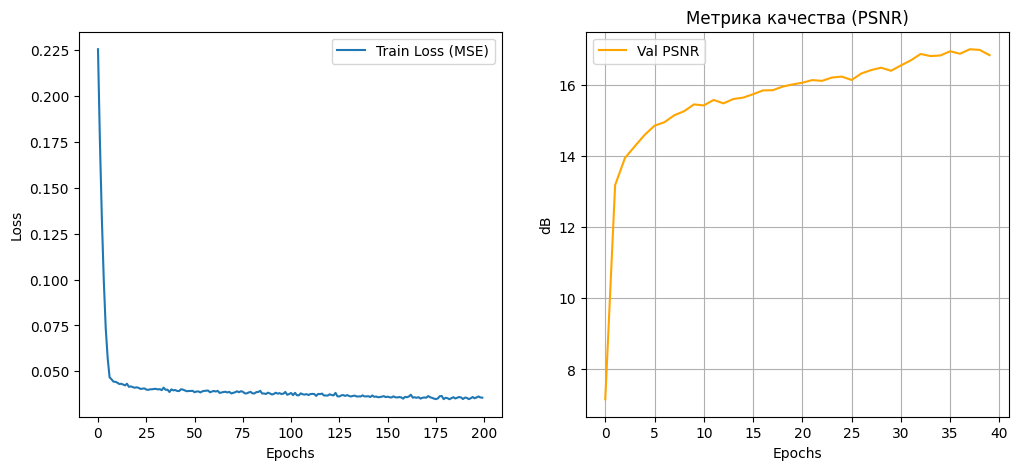

In [72]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(psnr_metric, label='Val PSNR', color='orange')
plt.title('Метрика качества (PSNR)')
plt.xlabel('Epochs')
plt.ylabel('dB')
plt.legend()
plt.grid(True)

plt.show()